In [1]:
import glob
import cv2 as cv

import ImageUtils as imu

import numpy as np # linear algebra
import joblib

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


from skimage.feature import hog
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Feature descriptors
def fd_hist(img):
    image = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hist = cv.calcHist([image], [0,1,2], None, [12, 8, 8], [0, 180, 0, 256, 0, 256])
    cv.normalize(hist, hist)
    return hist.flatten()


# here are the hog descriptor from the openCV tutorial for better understanding
# https://docs.opencv.org/trunk/dd/d3b/tutorial_py_svm_opencv.html

SZ=28
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR

def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img


def fd_hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist


# Load data

In [4]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Visualiza your data

train size: 60000, test size: 10000
8


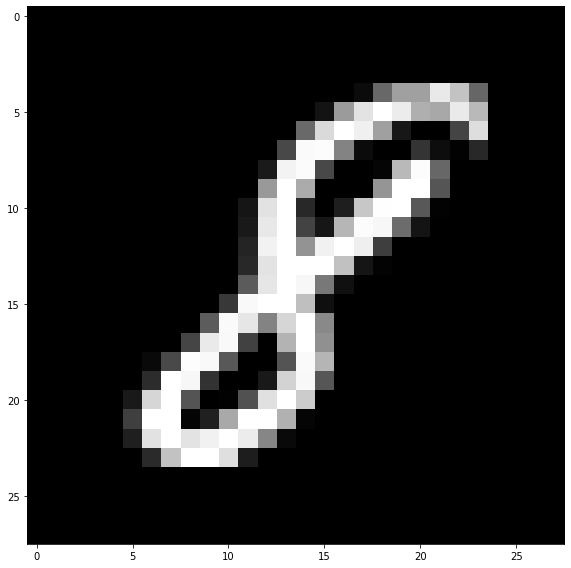

In [5]:
print("train size: {}, test size: {}".format(len(x_train), len(x_test)))
image_index = 7777
print(y_train[image_index])
imu.show(x_train[image_index])

# Visualize your Feature Engineering

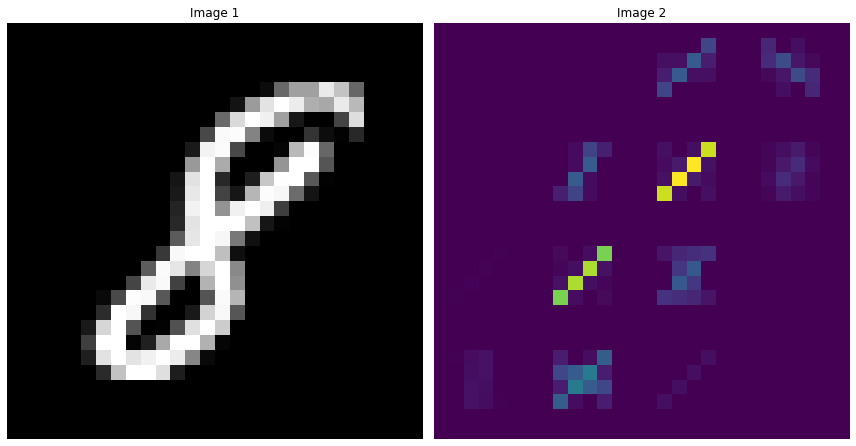

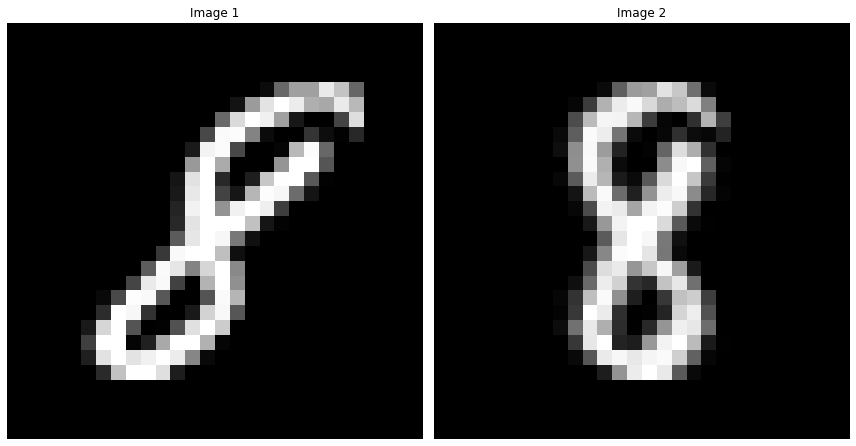

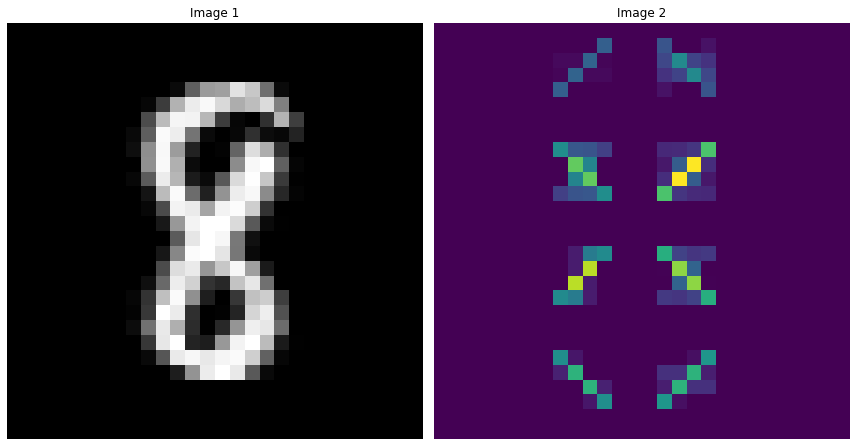

In [6]:
# Define pixels_per_cell part
ppc = 7

hog(x_train[image_index])
fd,hog_image = hog(x_train[image_index], orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
imu.show_comparison(x_train[image_index],hog_image)

deskew_img = deskew(x_train[image_index])
fd,hog_image = hog(deskew_img, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
imu.show_comparison(x_train[image_index],deskew_img, cmap='gray')
imu.show_comparison(deskew_img, hog_image)


# Calculate Features

In [7]:
# Calculate Features

feats_hog_train = [hog(deskew(i), orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),
                 block_norm= 'L2',visualize=False) for i in x_train ]

feats_hog_test = [hog(deskew(i), orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),
                 block_norm= 'L2',visualize=False) for i in x_test ]


feats_hog_train = [hog(deskew(i), orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),
                 block_norm= 'L2',visualize=False) for i in x_train ]

feats_hog_test = [hog(deskew(i), orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),
                 block_norm= 'L2',visualize=False) for i in x_test ]
# if more featues are added use :
# feats_train = np.hstack([feats_1, feats_3])

feats_train = feats_hog_train
feats_test = feats_hog_test

# Train, Test splits and Shuffle

In [8]:
# Load Classifier
# clf = joblib.load('svc_hh.pkl')
feats = np.array(feats_train)
labels = np.array(y_train).ravel()

# Shuffle data
X_train, X_test, Y_train, Y_test = train_test_split(
    feats, labels, test_size=0.2, random_state = 42)


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(48000, 128) (48000,)
(12000, 128) (12000,)


# Model Testing with Cross-Validation


Very important when the dataset is small and we want to better estimate the generalization error of our model over the dataset

Notice though that it may take a lot of extra time to train multiple models.

# Grid Search with Cross-Validation

In [9]:
# Set the parameters by cross-validation

tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [10, 1, 1e-1, 1e-2], 'C': [1, 10, 100, 1000]}]

# scores = ['precision', 'recall']
scores = ['f1']

In [10]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=2,
                       scoring='%s_macro' % score)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.5f (+/-%0.05f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.97113 (+/-0.00100) for {'C': 1, 'kernel': 'linear'}
0.97313 (+/-0.00044) for {'C': 10, 'kernel': 'linear'}
0.96992 (+/-0.00130) for {'C': 100, 'kernel': 'linear'}
0.96603 (+/-0.00090) for {'C': 1000, 'kernel': 'linear'}
0.94621 (+/-0.00243) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.97983 (+/-0.00045) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.96601 (+/-0.00049) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.94437 (+/-0.00041) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.94858 (+/-0.00292) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.98172 (+/-0.00057) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.97495 (+/-0.00042) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.96512 (+/-0.00029) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.94858 (+/-0.00292) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.98150 (+/-0.00036) for {'C': 100, 'g

# Train model

In [11]:
clf = svm.SVC(kernel='rbf', gamma=1, C=10).fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9841666666666666

In [12]:
y_pred = clf.predict(X_test)


print("Accuracy: "+str(accuracy_score(Y_test, y_pred)))
print('\n')
print(classification_report(Y_test, y_pred))

Accuracy: 0.9841666666666666


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1175
           1       0.99      0.99      0.99      1322
           2       0.98      0.99      0.98      1174
           3       0.99      0.98      0.99      1219
           4       0.97      0.98      0.98      1176
           5       0.99      0.98      0.99      1104
           6       0.99      0.99      0.99      1177
           7       0.98      0.98      0.98      1299
           8       0.98      0.98      0.98      1160
           9       0.97      0.97      0.97      1194

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



# Testing

After we validate our model, normally I separate new data which the model has never been trained before in order to test our model. In this case I will use the original separated test data from the dataset for testing afver validating with training split.

In [13]:
# Calculate Features

feats = np.array(feats_hog_test)
labels = np.array(y_test).ravel()


# feats = [fd_hist(i) for i in train_img]
# feats = feats_b
print(len(feats))

feats = np.array(feats)
labels = np.array(labels)
labels = labels.reshape(labels.shape[0],1)
data_frame = np.hstack((feats,labels))



x = data_frame[:,:-1]
y = data_frame[:,-1:].ravel()

y_pred = clf.predict(x)


print("Accuracy: "+str(accuracy_score(y, y_pred)))
print('\n')
print(classification_report(y, y_pred))

10000
Accuracy: 0.9849


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.98      0.99      0.98      1032
         3.0       0.98      0.99      0.98      1010
         4.0       0.98      0.99      0.99       982
         5.0       0.98      0.98      0.98       892
         6.0       0.99      0.99      0.99       958
         7.0       0.98      0.98      0.98      1028
         8.0       0.98      0.97      0.98       974
         9.0       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# Visualize errors

Sometimes you wanna visualize the features of the errors in order to add features or make it better

5


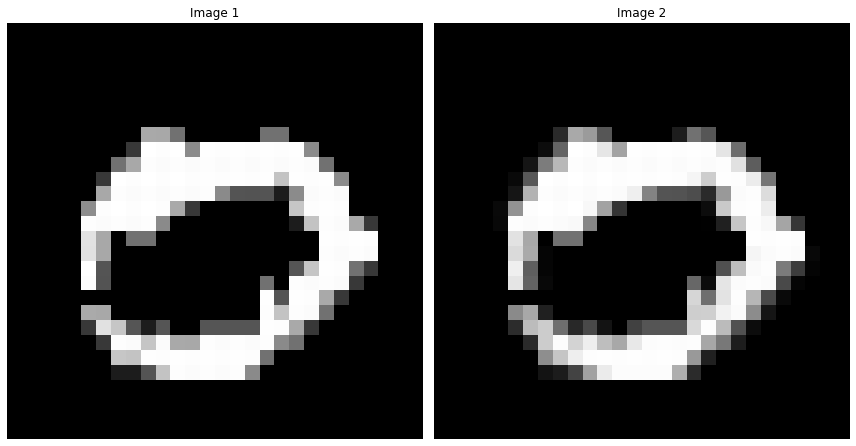

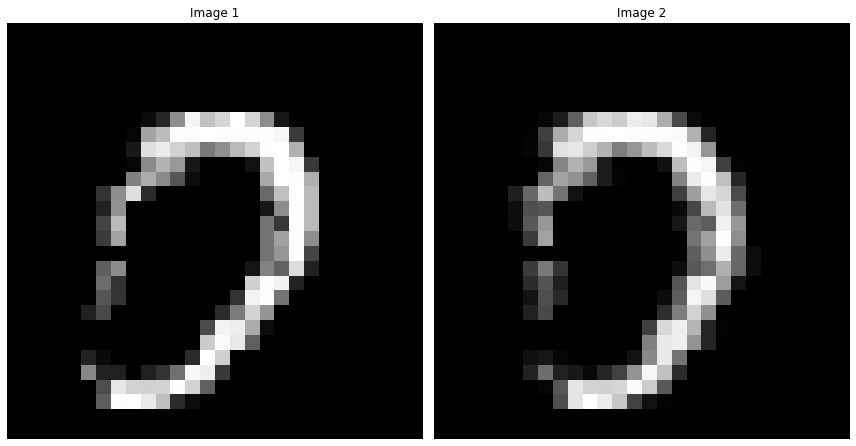

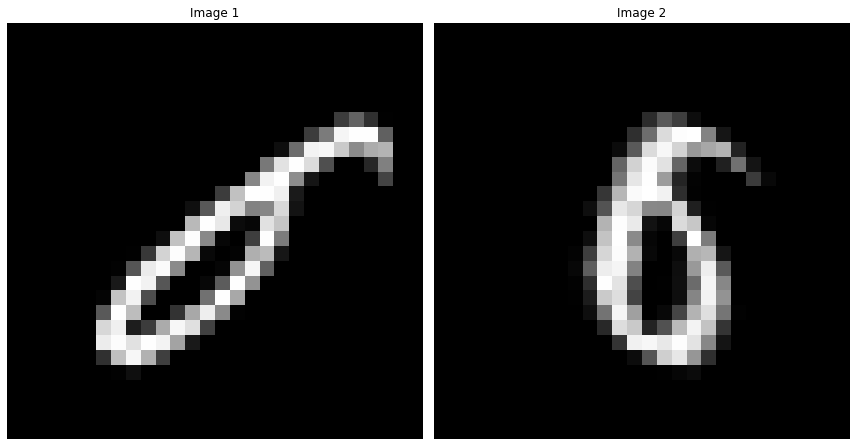

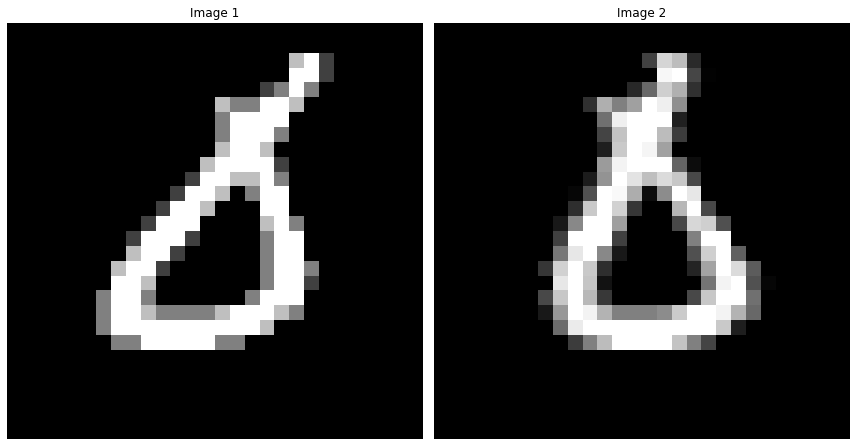

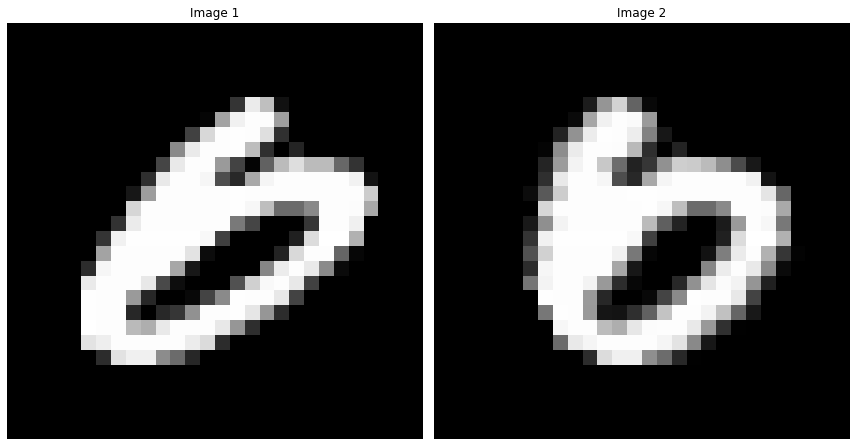

In [14]:
err_vec = [i for i, x in enumerate(y_pred) if y[i] != y_pred[i] and y[i]==0]
print(len(err_vec))

for i in range(len(err_vec[:10])):
    imu.show_comparison(x_test[err_vec[i]], deskew(x_test[err_vec[i]]), cmap='gray')

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

128
32


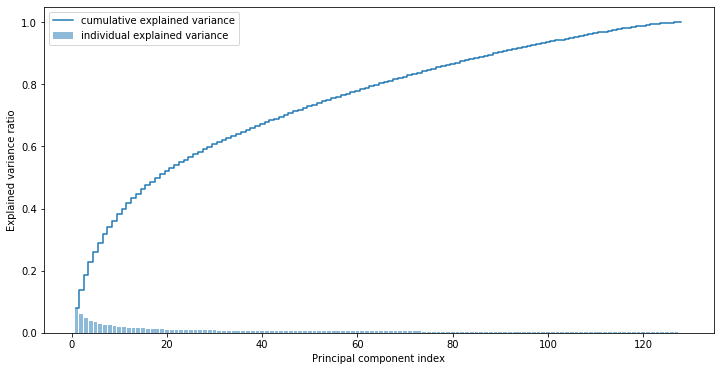

In [16]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print(len(var_exp))
print(len(range(1,33)))

# plot explained variances
plt.figure(figsize=(12, 6))
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5,align='center', label='individual explained variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [17]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()

pca = PCA(n_components=2) 
transformed = pca.fit_transform(feats)

print(transformed.shape)

(10000, 2)


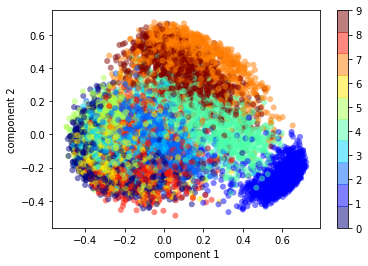

In [18]:
plt.scatter(transformed[:, 0], transformed[:, 1],
            c=labels.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# Save Model

In [19]:
joblib.dump(clf, "svc_mnist.pkl")

['svc_mnist.pkl']

# Loading later: 


```
clf = joblib.load("svc_mnist.pkl") 
```